Running a Tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def trueprocess(mu: float, N: int =1000):
  x = rng.normal(size=N, loc=mu)
  xnoise = x + rng.normal(size=N)
  y = np.maximum(0.0, xnoise)
  df = pd.DataFrame({'x': x, 'y': y})
  return df

traind = trueprocess(mu=0, N=1000)

lm0 = LinearRegression()
lm0.fit(
    traind.loc[:, ['x']],
    traind.loc[:, 'y'],
)
traind['ypred0'] = np.maximum(0, lm0.predict(traind.loc[:, ['x']]))

traind.head()

,x,y,ypred0
0,1.028857,1.909897,1.074885
1,1.641920,0.797920,1.389797
2,1.146720,0.000000,1.135428
3,-0.973180,0.000000,0.046500
4,-1.392800,0.000000,0.000000


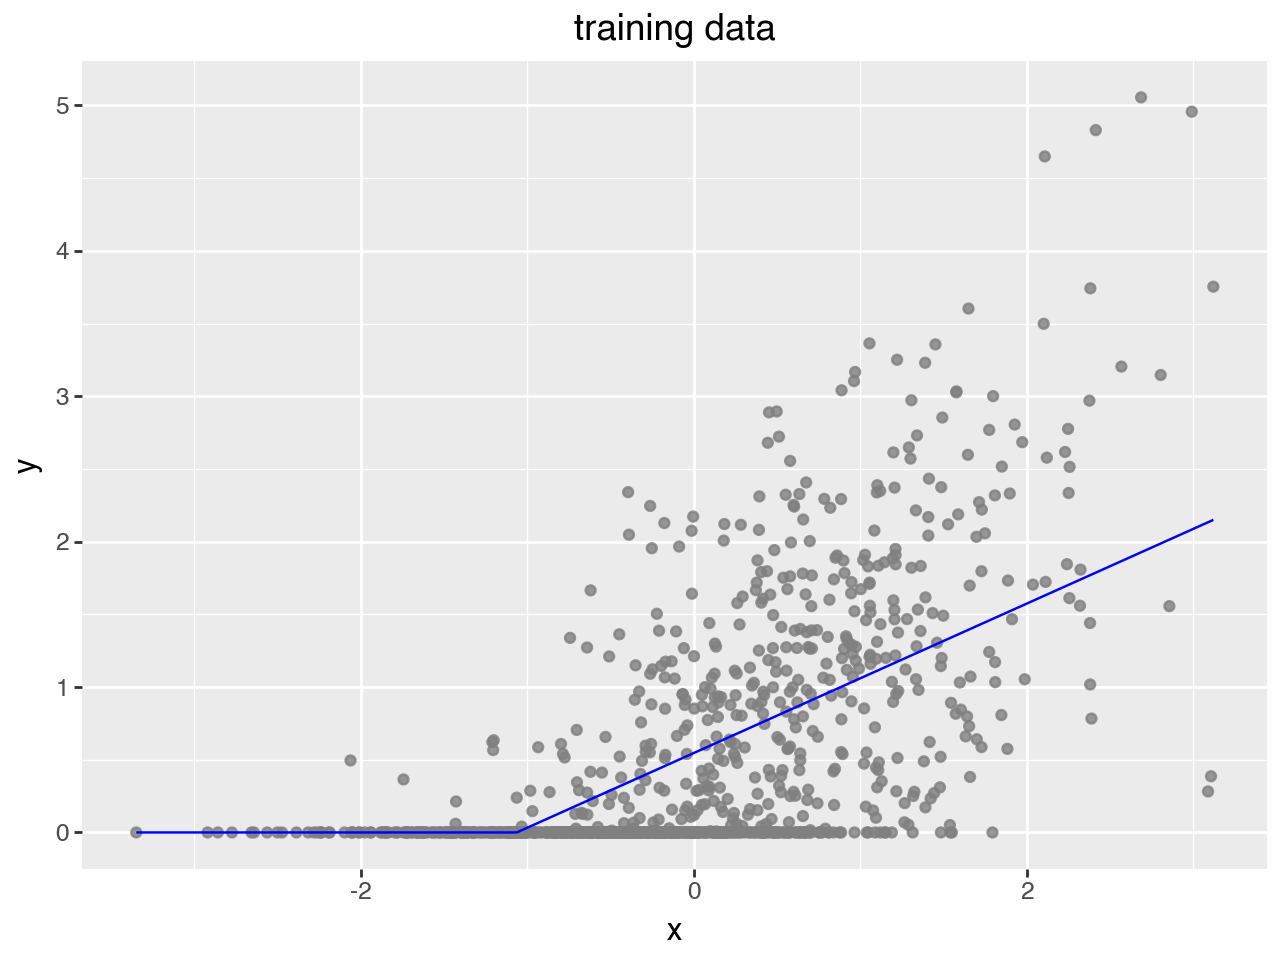

In [4]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue") + 
    ggtitle("training data")
)

In [5]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zeros observations
  vector[N_positive] p_pos;  // observed predictions (to be adjusted to match outcomes)
  vector[N_positive] y_pos;  // observed outcomes
  vector[N_zero] p_zero;     // observed predictions (to be adjusted to match zero outcomes)
}
parameters {
  real a;               // regression slope
  real b;               // regression intercept
  real<lower=0> sigma;  // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // Tobit style model structure
  y_pos ~ normal(a * p_pos + b, sigma);
  target += normal_lcdf( 0 | a * p_zero + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [6]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)

model

CmdStanModel: name=tobit_tmp
	 stan_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp.stan
	 exe_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp
	 compiler_options=stanc_options={}, cpp_options={}

In [7]:
pos_positions = traind['y'] > 0
p_pos = list(traind['ypred0'][pos_positions])
y_pos = list(traind['y'][pos_positions])
p_zero = list(traind['ypred0'][pos_positions == False])

In [8]:
data_str = f"""
{{
"N_positive" : {len(p_pos)},
"N_zero" : {len(p_zero)},
"p_pos" : {p_pos},
"y_pos" : {y_pos},
"p_zero" : {p_zero}
}}
"""

print(data_str)


{
"N_positive" : 477,
"N_zero" : 523,
"p_pos" : [1.074885339018591, 1.3897973349637143, 0.5809094326809312, 0.9888425985575152, 1.476281614431481, 0.8750178207655368, 1.3088869262112972, 0.5715175198550643, 0.14795003245565302, 1.0102688727359213, 0.20301973252747246, 0.43242913913513226, 0.6862447706498189, 0.7644810769784999, 0.661939309719601, 1.397894832168288, 1.1623788552332006, 1.1685466438001937, 0.8722138967217699, 0.9461679810957063, 1.4957403081284206, 0.4874244678926414, 0.7488808848607325, 0.41191890346141957, 1.2322808633912166, 1.1964170843225173, 0.9110870287250117, 0.10134878742374775, 0.8560930788155288, 1.1348924226483186, 1.0019674527035796, 0.7608933018219955, 1.5601483522986634, 0.5972808867316904, 0.8228537308758008, 1.0886438133549474, 0.4243877304900508, 0.5157708040281237, 0.9525393998723148, 0.6208796649705898, 1.1773680026920845, 1.0010576023986852, 0.7637071369630477, 1.701537352328975, 0.7838550279246566, 0.7475590902851317, 0.5209509945331896, 1.73828801

In [9]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [10]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [11]:
res = fit.draws_pd()

In [12]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,-499.089,0.986532,0.357943,3.0,15.0,0.0,499.462,2.11272,-1.29833,1.005690
1,-498.937,0.914969,0.357943,3.0,15.0,0.0,500.185,2.17045,-1.31020,1.043230
2,-498.624,0.877406,0.357943,3.0,11.0,0.0,500.164,2.21270,-1.38298,1.031920
3,-499.349,0.933361,0.357943,2.0,7.0,0.0,499.892,2.21062,-1.41565,1.040850
4,-499.135,0.999929,0.357943,3.0,11.0,0.0,499.559,2.11586,-1.30565,1.006240
...,...,...,...,...,...,...,...,...,...,...
3995,-499.645,0.836882,0.330019,3.0,7.0,0.0,502.137,2.24815,-1.39980,0.996272
3996,-499.628,0.970814,0.330019,3.0,7.0,0.0,501.157,2.26312,-1.36253,0.998593
3997,-500.372,0.985424,0.330019,3.0,11.0,0.0,501.481,2.20875,-1.33610,0.968489
3998,-498.671,0.855808,0.330019,4.0,15.0,0.0,501.838,2.21554,-1.37028,1.014910


In [13]:
a = res['a'].mean()
b = res['b'].mean()

(a, b)

(2.196760285, -1.350524645)

In [14]:
traind['Tobit prediction'] = np.maximum(0, a * traind['ypred0'] + b)

traind

,x,y,ypred0,Tobit prediction
0,1.028857,1.909897,1.074885,1.010741
1,1.641920,0.797920,1.389797,1.702527
2,1.146720,0.000000,1.135428,1.143738
3,-0.973180,0.000000,0.046500,0.000000
4,-1.392800,0.000000,0.000000,0.000000
...,...,...,...,...
995,-1.086436,0.000000,0.000000,0.000000
996,-0.508474,1.210484,0.285205,0.000000
997,0.513753,0.000000,0.810292,0.429493
998,-0.203761,0.000000,0.441727,0.000000


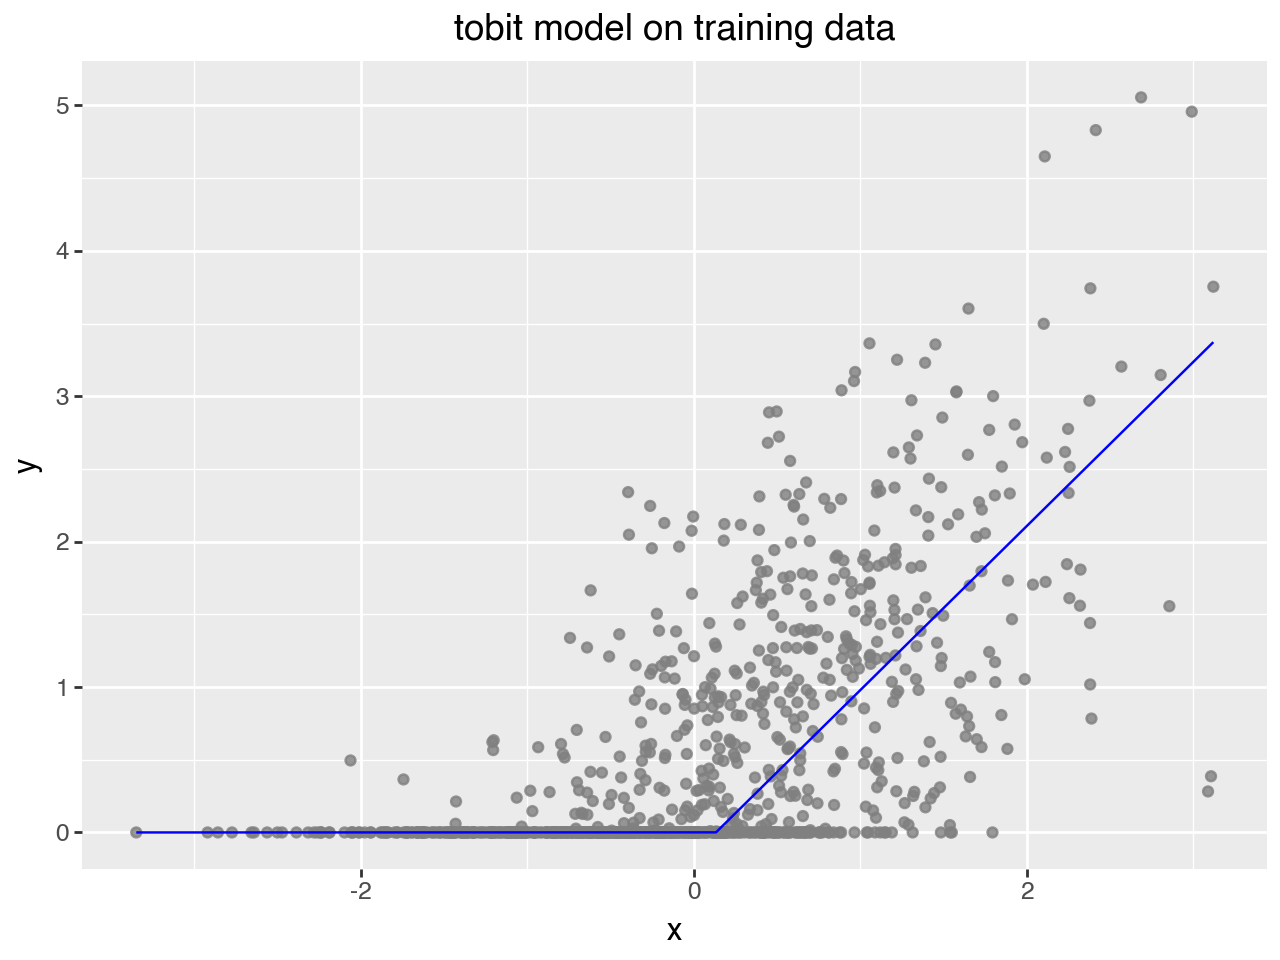

In [15]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='Tobit prediction'),
        color="blue") +
    ggtitle("tobit model on training data")
)

In [16]:
consider_pos_for_lm = traind['ypred0'] > 0  # note: do get a better fit for traind['y'] > 0 cut, but that ignores data near zero.
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm, ['ypred0']],
    traind.loc[consider_pos_for_lm, 'y'],
)
traind['linear prediction (prediction correction cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

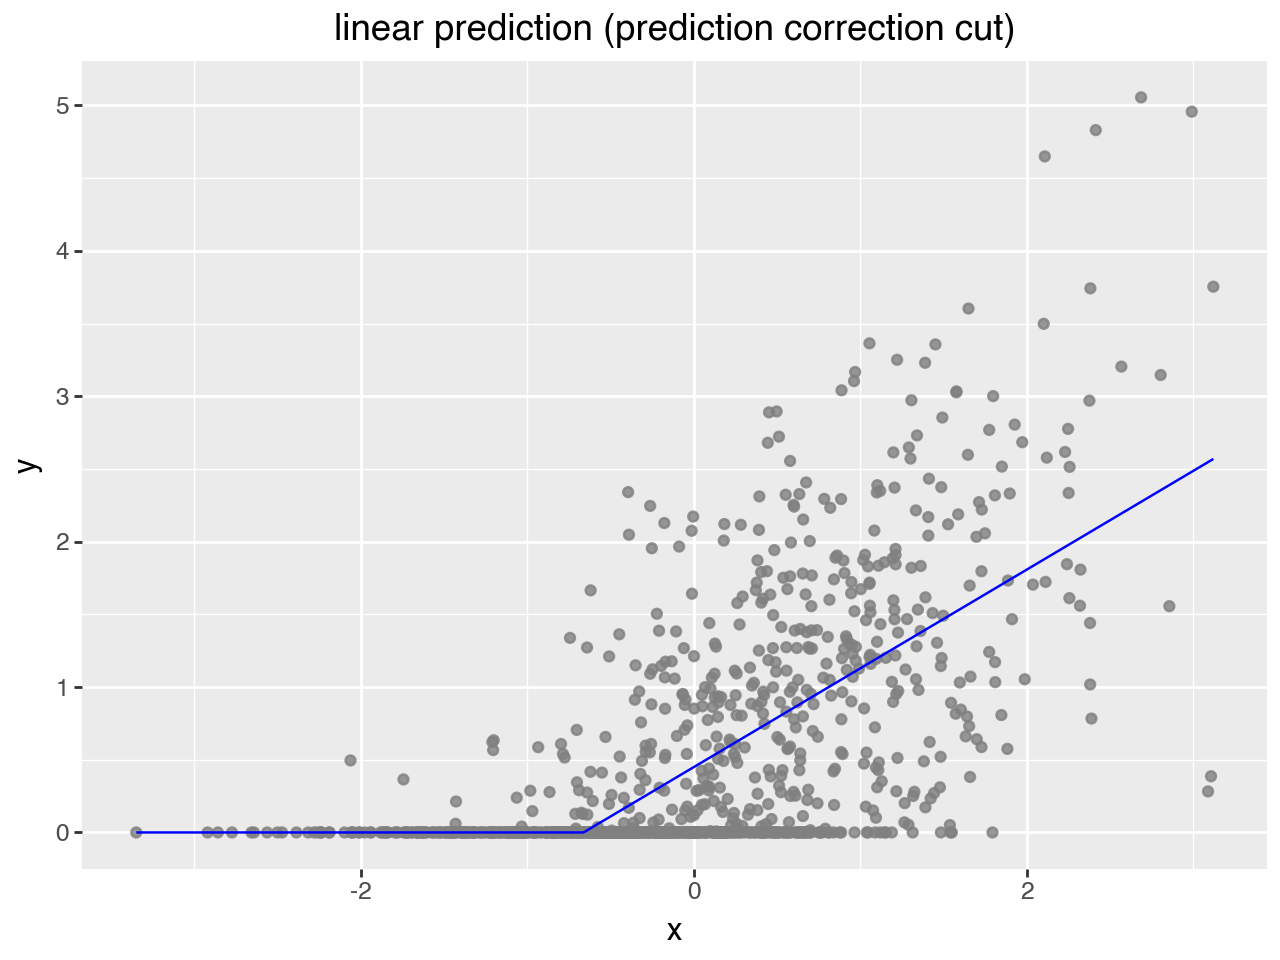

In [17]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (prediction correction cut)'),
        color="blue") +
    ggtitle("linear prediction (prediction correction cut)")
)

In [18]:
(lm.coef_, lm.intercept_)

(array([1.32169906]), -0.27274097800051067)

In [19]:
consider_pos_for_lm_p = traind['y'] > 0
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm_p, ['ypred0']],
    traind.loc[consider_pos_for_lm_p, 'y'],
)
traind['linear prediction (target threshold cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

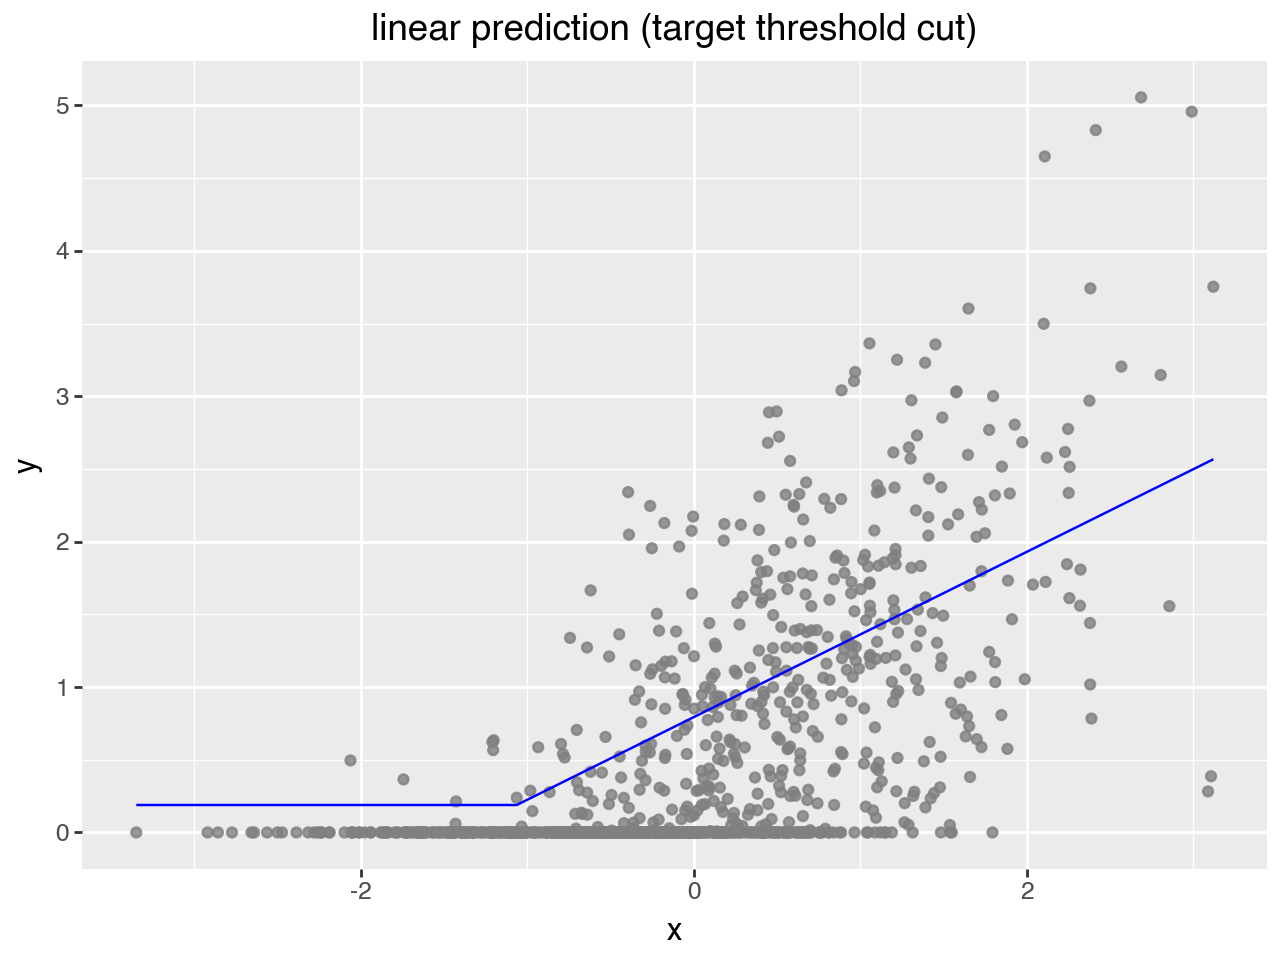

In [20]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (target threshold cut)'),
        color="blue") +
    ggtitle("linear prediction (target threshold cut)")
)